# Case 1

## Packages needed

In [56]:
import scipy.io
import numpy as np
import pandas as pd
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load data

In [57]:
df = pd.read_csv('case1Data.txt', delimiter = ",",na_values=[np.nan])
y, X = df['y'], df.drop(['y'],axis=1)

In [58]:
X

,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,10.055585,0.289036,-46.748373,9.289237,9.729013,17.036793,-12.430320,11.015882,2.256337,-6.317563,...,9.799563,15.842689,-9.527268,8.680547,6.870564,NaN,I,NaN,H,K
1,5.661929,-8.172350,-51.445846,2.869381,5.857869,16.976673,-14.625289,1.945814,-7.452895,-17.569241,...,-2.533666,12.984296,-9.138499,1.790938,-0.278660,K,I,I,I,K
2,1.420570,-7.479476,-51.696962,-1.654729,4.731166,9.848327,-15.459621,3.922184,-1.210801,-15.128570,...,3.461843,15.294486,-13.668956,5.448614,1.847178,G,H,I,J,K
3,7.716013,-7.750335,-49.142539,1.118904,5.283744,16.822317,-12.166760,1.292544,-2.182322,-19.531119,...,4.470430,17.564489,-13.049522,3.505629,2.672849,I,I,J,G,J
4,5.195233,-8.252987,-52.143856,2.112213,2.034861,12.717198,-22.389714,1.438919,-7.308590,-16.706968,...,-1.374044,11.119488,-9.881581,2.819918,-0.221832,I,H,K,J,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.044536,-11.901705,-57.634110,0.585180,-0.573642,9.577615,-18.772640,-4.658674,0.051841,-20.648131,...,-0.450982,11.946267,-17.266451,1.713502,-1.226736,G,NaN,J,G,I
96,3.887832,-8.220962,-52.190722,3.819770,9.249362,11.697782,-17.493330,6.459572,-3.720986,-18.296493,...,2.301361,13.178355,-14.020578,4.797613,4.851088,G,H,NaN,K,I
97,0.572669,-13.366162,-53.367310,-3.833560,2.479605,12.082965,-16.647158,-3.008845,-7.150218,-22.477569,...,2.053157,8.692936,-10.018546,1.718793,-1.793283,I,NaN,K,I,K
98,10.839996,-8.584820,-53.903515,3.059798,6.972408,14.901020,-12.060797,0.383123,0.959513,-15.599672,...,6.686734,12.455089,-13.546147,4.977827,0.398284,K,I,I,K,H


## Data Prep

### Missing values
There are multiple ways to handle missing values. But the simplest one is simply to one-hot-encode the categorical variables, where NaN also will be a variable. 

https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

In [59]:
X = pd.get_dummies(X, prefix=["C_1","C_2","C_3","C_4","C_5"], dummy_na=True)

In [60]:
for i in range(1,6):
    print(X[f'C_{i}_nan'].unique())

#since they all only contain zero, we can drop them.

[0]
[0]
[0]
[0]
[0]


In [61]:
X = X.drop(['C_1_nan','C_2_nan','C_3_nan','C_4_nan','C_5_nan'],axis=1)

In [62]:
[n,p] = X.shape

## Model development

### Baseline

In [63]:
# Estimate the noise of the data

def EstimateNoise(betas, X, y):
    
    rss = np.sum((y - np.matmul(X, betas)) ** 2 )
    noise = rss / (n - p - 1) 
    
    return noise

# Calculate an unbiased OLS estimate using linalg.lstsq

betas, res, rank, s = linalg.lstsq(X, y) 
sigma_hat_squared = EstimateNoise(betas, X, y)

print(sigma_hat_squared)

-5.102571115918626e-12


In [64]:
#analytical version
rss = np.sum(res)
print(f'rss: {rss}')
tss = np.sum((y-np.mean(y)) ** 2)
print(f'tss: {tss}')
r_squared = (1 - rss/tss) * 100
print(f'R-squared: {r_squared}')

#Overfitting from the beta values!!

rss: 0.0
tss: 539289.4362462863
R-squared: 100.0


### LARS

In [65]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

In [66]:
# Set up cross validation like you did last week
Fold = 5 # if K = n leave-one-out, you may try different numbers
CV = KFold(n_splits = Fold)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs 
stop = n-math.ceil(n/Fold)
K = range(stop)

Err_tr = np.zeros((Fold,len(K)))
Err_tst = np.zeros((Fold, len(K))) 

# For each chunk of data; run ridge for each lambda and calculate mean squared error
k=0
for train_index, test_index in CV.split(X,y):
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    X_train, mu_X_train = centerData(X.iloc[train_index,:])
    y_train, mu_y_train = centerData(y[train_index]) # ravel collapses the array, ie dim(x,1) to (x,)
    X_test = X.iloc[test_index,:] - mu_X_train
    y_test = y[test_index].ravel() - mu_y_train # ravel collapses the array, ie dim(x,1) to (x,)
    
    #normalize
    normalizer = preproc.Normalizer().fit(X_train.T)  
    X_train = normalizer.transform(X_train.T).T
    X_test = normalizer.transform(X_test.T).T
    
    for i in K:
        lars = linear_model.Lars(n_nonzero_coefs = i)
        lars.fit(X_train, y_train)
        
        #pred
        pred_tr = lars.predict(X_train)
        pred_tst = lars.predict(X_test)
        
        
        Err_tr[k-1, i] = np.square(y_train - pred_tr).sum() / y_train.shape[0]
        Err_tst[k-1, i] = np.square(y_test - pred_tst).sum() / y_test.shape[0]
        
    
    print('Cross validation fold {0}/{1}'.format(k+1,Fold))
    k=k+1
    


err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(Fold) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

Cross validation fold 1/5
Cross validation fold 2/5
Cross validation fold 3/5
Cross validation fold 4/5
Cross validation fold 5/5


In [67]:
# Compute Cp-statistic, assumption n > p

betas = np.zeros((p,n))

for i in range(n):
    lars = linear_model.Lars(n_nonzero_coefs = i, normalize = True)
    lars.fit(X,y)
    betas[:,i] = lars.coef_
    
Cp = np.zeros((len(K)))
for i in range(len(K)):
    yhat = np.matmul(X, betas[:,K[i]])
    Cp[i] = np.mean((y - yhat) ** 2) + 2 * K[i]/n*sigma_hat_squared

C:\Users\Miche\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=5.125e-01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Miche\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=5.125e-01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Miche\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=5.125e-01, with an active set of 68 regressors, and the smallest chole

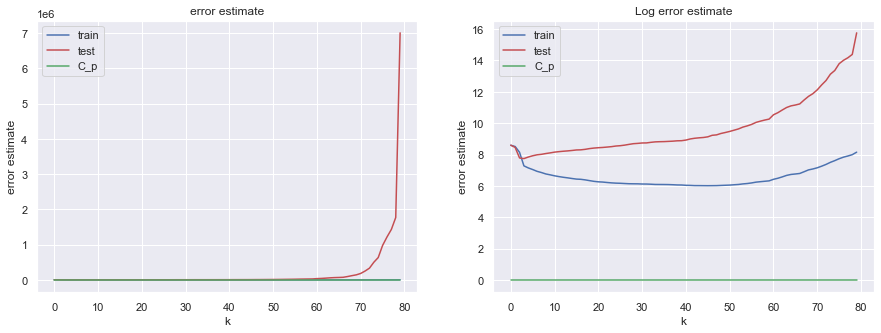

In [68]:
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()